# Submission 2. Fast-ai

| Variable | Definition                      | Key                                         |
|----------|---------------------------------|---------------------------------------------|
| survival | Survival                        | 0 = No, 1 = Yes                             |
| pclass   | Ticket class                    | 1 = 1st, 2 = 2nd, 3 = 3rd                   |
| sex      | Sex                             |                                             |
| Age      | Age in years                    |                                             |
| sibsp    | # of siblings / spouses aboard the Titanic |                               |
| parch    | # of parents / children aboard the Titanic  |                               |
| ticket   | Ticket number                   |                                             |
| fare     | Passenger fare                  |                                             |
| cabin    | Cabin number                    |                                             |
| embarked | Port of Embarkation             | C = Cherbourg, Q = Queenstown, S = Southampton |

In [1]:
import pandas as pd
from pathlib import Path
import os
from fastai.tabular.all import *

In [2]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('../input/titanic')
    !pip install -Uqq fastai
else:
    import zipfile,kaggle
    path = Path('titanic')
    if not path.exists():
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 34.1k/34.1k [00:00<00:00, 439kB/s]

In [ ]:
pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

In [4]:
# Read train and test files into pandas dataframes
df = pd.read_csv('train.csv')
df_submission = pd.read_csv('test.csv')

# Preprocessing


Feature Engineering

In [6]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC",B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))

add_features(df)

# Modeling

Prepare Dataloader

In [7]:
# Create splits
splits = RandomSplitter(seed=42)(df)

In [8]:
# Create DataLoader
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare',
                 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", y_block = CategoryBlock(),
).dataloaders(path=".")

Model Building

In [17]:
# Create learner. Size of each hidden layer ([100,50])
learn = tabular_learner(dls, layers=[10,10], metrics=accuracy)

SuggestedLRs(slide=0.0831763744354248, valley=0.010964781977236271)

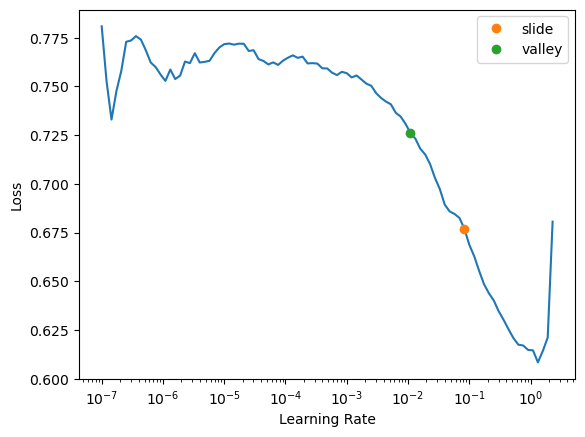

In [18]:
# Finding google learning rate
learn.lr_find(suggest_funcs=(slide, valley))

# Train the model

In [19]:
learn.fit(16, lr=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.581009,0.535843,0.679775,00:00
1,0.510859,0.440614,0.775281,00:00
2,0.475965,0.493701,0.820225,00:00
3,0.454457,0.429261,0.820225,00:00
4,0.439288,0.413073,0.842697,00:00
5,0.428202,0.417552,0.837079,00:00
6,0.419057,0.410243,0.837079,00:00
7,0.417295,0.419367,0.842697,00:00
8,0.411169,0.431529,0.825843,00:00
9,0.403019,0.445085,0.808989,00:00


# Submit to Kaggle

Prepare the data

In [20]:
df_submission = pd.read_csv(path/'test.csv') # Read test file
df_submission['Fare'] = df_submission.Fare.fillna(0)# There is one Fare missing
add_features(df_submission) # Add features to test dataframe
dl_test = learn.dls.test_dl(df_submission) # Create DataLoader for test dataframe from the configurations of the learner

Get predictions

In [21]:
preds,_=learn.get_preds(dl=dl_test) # Get predictions

Create submission file

In [22]:
df_submission['Survived'] = (preds[:,1]>0.5).int() # Add predictions to dataframe
sub_df_submission = df_submission[['PassengerId','Survived']] # Create submission dataframe
sub_df_submission.to_csv('sub2.csv', index=False) # Save submission dataframe to csv file

In [23]:
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,0
899,0
900,1


In [24]:
!kaggle competitions submit -c titanic -f sub2.csv -m "Fastai Tabular Learner with 10,10 layers. 16 epochs. 0.03 learning rate. 0.5 threshold."

100%|██████████████████████████████████████| 2.77k/2.77k [00:00<00:00, 3.97kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster